In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager, rc
import platform
from sklearn import preprocessing
import re

if platform.system() == 'Darwin':
    rc('font', family = 'AppleGothic')
elif platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname = 'c:/Windows/Fonts/malgun.ttf').get_name()
    rc('font', family=font_name)

## 요일, 시간 전처리

In [2]:
# data 로드
vod = pd.read_csv('vod_prepro_series_nm.csv')
con = pd.read_csv('con_prepro_series_nm.csv', encoding='cp949')

In [3]:
vod.rename(columns={'strt_dt':'log_dt'}, inplace=True)
vod['log_dt'] = pd.to_datetime(vod['log_dt'], format='%Y%m%d%H%M%S')
vod.drop_duplicates(inplace=True)
vod[vod.duplicated()]
vod

,subsr,asset_nm,ct_cl,genre_of_ct_cl,use_tms,SMRY,ACTR_DISP,disp_rtm,log_dt,Category,rename,vod_id
0,65941000,그것이알고싶다,TV 시사/교양,기타,80.0,살인자의 자백 그리고 아크말의 고백. 방대한 수사기록과 당시 아크말의 진술을 토대로...,김상중,80,2023-08-12 16:35:07,TV프로그램,그것이알고싶다,297
1,66873000,그것이알고싶다,TV 시사/교양,기타,80.0,살인자의 자백 그리고 아크말의 고백. 방대한 수사기록과 당시 아크말의 진술을 토대로...,김상중,80,2023-08-16 20:52:27,TV프로그램,그것이알고싶다,297
2,66873000,그것이알고싶다,TV 시사/교양,기타,12.0,살인자의 자백 그리고 아크말의 고백. 방대한 수사기록과 당시 아크말의 진술을 토대로...,김상중,80,2023-08-29 19:47:27,TV프로그램,그것이알고싶다,297
3,61689000,그것이알고싶다,TV 시사/교양,기타,80.0,살인자의 자백 그리고 아크말의 고백. 방대한 수사기록과 당시 아크말의 진술을 토대로...,김상중,80,2023-08-13 13:06:09,TV프로그램,그것이알고싶다,297
4,61619000,꼬리에꼬리를무는그날이야기,TV 시사/교양,기타,69.7,"살인범의 미토콘드리아 - 2006 냉동고 살인사건. 2006년 7월 23일, 서울 ...","장도연,장현성,장성규",73,2023-08-04 09:27:37,TV프로그램,꼬리에꼬리를무는그날이야기,8
...,...,...,...,...,...,...,...,...,...,...,...,...
10156,60169000,간질간질,키즈,학습,6.0,인기작가 서현의 그림책! 온몸으로 읽는 그림책 간질간질. 글자가 형태로 보이지 않고...,-,6,2023-09-14 21:11:10,키즈,간질간질,3674
10157,66317000,알사탕,키즈,학습,8.0,"인기 작가 백희나 신간. 교보문고, YES24 베스트셀러! 상대방의 입장을 헤아리고...",-,8,2023-09-03 22:35:44,키즈,알사탕,3671
10158,66317000,알사탕,키즈,학습,3.3,"인기 작가 백희나 신간. 교보문고, YES24 베스트셀러! 상대방의 입장을 헤아리고...",-,8,2023-09-03 22:32:10,키즈,알사탕,3671
10159,66900000,월간 아기상어,키즈,학습,0.8,8-Bit Baby Shark. 오락실에 아기 상어가 나타났다?! 추억의 8비트 버...,아기상어,1,2023-09-04 12:00:57,키즈,월간아기상어,406


In [4]:
con['asset_nm'] = con['series_nm']
con.drop(['series_nm', 'super_asset_nm'], axis=1, inplace=True)
con['log_dt'] = pd.to_datetime(con['log_dt'], format='%Y%m%d%H%M%S')
con.drop_duplicates(inplace=True)
con[con.duplicated()]
con

,subsr,ct_cl,genre_of_ct_cl,SMRY,ACTR_DISP,disp_rtm,log_dt,Category,rename,vod_id,asset_nm
0,65968000,키즈,기타,"겨울잠. 숲, 바다, 극지방 등 세계 여러 곳에 사는 동물 친구들을 만나러 가자! ...",핑크퐁,1,2023-08-13 07:11:55,키즈,핑크퐁동물동요,882,핑크퐁 동물 동요
1,65968000,키즈,기타,"겨울잠. 숲, 바다, 극지방 등 세계 여러 곳에 사는 동물 친구들을 만나러 가자! ...",핑크퐁,1,2023-08-13 07:12:15,키즈,핑크퐁동물동요,882,핑크퐁 동물 동요
2,63086000,키즈,기타,로봇 세상에서 킥보드를 타요. 로보카 폴리 브룸스 타운에서 킥보드를 타요~ / 새로...,"헤이지니,럭키강이",11,2023-08-27 14:55:42,키즈,지니강이플러스시즌7,1622,지니강이 플러스 시즌7
3,63086000,키즈,기타,지니가 화장품으로 슬라임을 만들어요. / 슈퍼히어로 강이! 문을 열면 춤을 춰요.,"헤이지니,럭키강이",11,2023-08-27 15:24:17,키즈,지니강이플러스시즌9,2043,지니강이 플러스 시즌9
4,62733000,키즈,기타,미니 시리얼 팬케이크 만들기.,-,13,2023-08-16 11:28:16,키즈,엘리가간다시즌12,1958,엘리가간다 시즌12
...,...,...,...,...,...,...,...,...,...,...,...
21122,64551000,키즈,학습,"[교보문고,YES24,알라딘 베스트셀러] 경주에 진 그 토끼는 어떻게 되었을까? 내...",-,12,2023-09-30 12:16:57,키즈,슈퍼토끼,544,슈퍼 토끼
21123,64551000,키즈,학습,"[교보문고,YES24,알라딘 베스트셀러] 경주에 진 그 토끼는 어떻게 되었을까? 내...",-,12,2023-09-30 12:16:54,키즈,슈퍼토끼,544,슈퍼 토끼
21124,64551000,키즈,학습,"[교보문고,YES24,알라딘 베스트셀러] 경주에 진 그 토끼는 어떻게 되었을까? 내...",-,12,2023-09-30 12:16:56,키즈,슈퍼토끼,544,슈퍼 토끼
21125,64551000,키즈,학습,"[교보문고,YES24,알라딘 베스트셀러] 경주에 진 그 토끼는 어떻게 되었을까? 내...",-,12,2023-09-30 12:16:46,키즈,슈퍼토끼,544,슈퍼 토끼


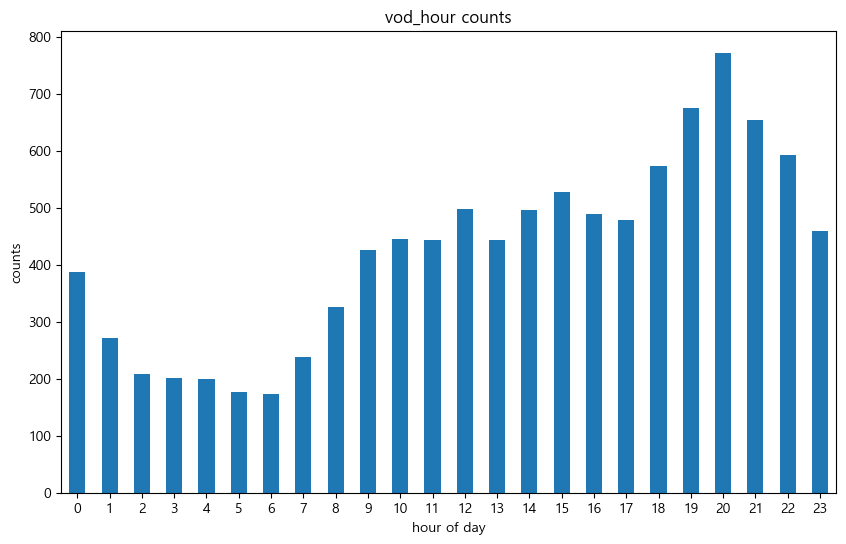

In [5]:
# 시간 추출
vod['hour'] = vod['log_dt'].dt.hour
hour_counts = vod['hour'].value_counts().sort_index()

plt.figure(figsize=(10,6))
hour_counts.plot(kind='bar')
plt.title('vod_hour counts')
plt.xlabel('hour of day')
plt.ylabel('counts')
plt.xticks(rotation=0)
plt.show()

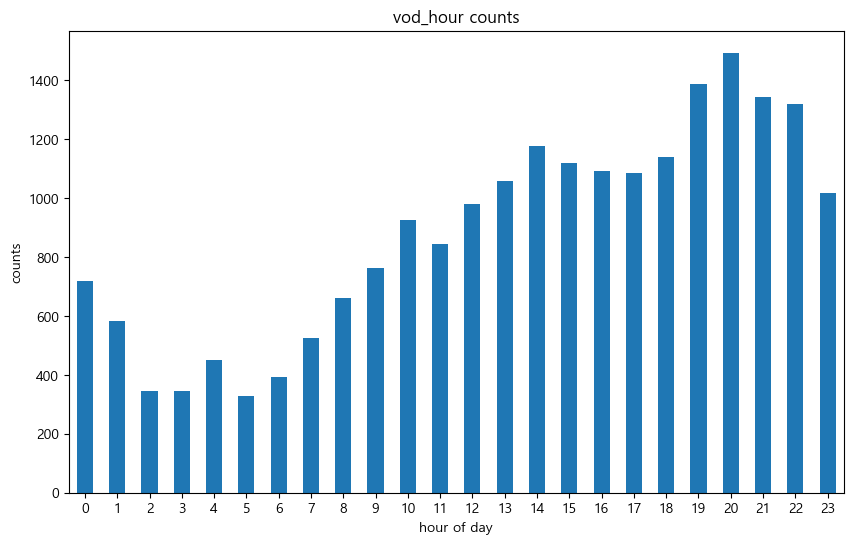

In [6]:
# 시간 추출
con['hour'] = con['log_dt'].dt.hour
con_hour_counts = con['hour'].value_counts().sort_index()

plt.figure(figsize=(10,6))
con_hour_counts.plot(kind='bar')
plt.title('vod_hour counts')
plt.xlabel('hour of day')
plt.ylabel('counts')
plt.xticks(rotation=0)
plt.show()

In [7]:
# api 이용하여 한국 공휴일 정보 가져옴
import requests
from urllib import parse
from bs4 import BeautifulSoup
from datetime import datetime

In [8]:
api_key_utf8 = '8rnsD4jDA580O81rnMuiKsWHB9HCb7O9MNFmEQfG6rPCfTbr0IN%2F7hl3tSBrvvaVHUaAHUDpoT2ct6Whj6Bl3g%3D%3D'
api_key_decode = '8rnsD4jDA580O81rnMuiKsWHB9HCb7O9MNFmEQfG6rPCfTbr0IN/7hl3tSBrvvaVHUaAHUDpoT2ct6Whj6Bl3g=='
solYear = 2023

url_holiday = f'http://apis.data.go.kr/B090041/openapi/service/SpcdeInfoService/getRestDeInfo?solYear={solYear}&ServiceKey={api_key_decode}&numOfRows=100'

response = requests.get(url_holiday)
xml = BeautifulSoup(response.text, 'lxml')
xml

C:\Users\USER\anaconda3\lib\site-packages\bs4\builder\__init__.py:545: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  warnings.warn(


<?xml version="1.0" encoding="UTF-8" standalone="yes"?><html><body><response><header><resultcode>00</resultcode><resultmsg>NORMAL SERVICE.</resultmsg></header><items><item><datekind>01</datekind><datename>1월1일</datename><isholiday>Y</isholiday><locdate>20230101</locdate><seq>1</seq></item><item><datekind>01</datekind><datename>설날</datename><isholiday>Y</isholiday><locdate>20230121</locdate><seq>1</seq></item><item><datekind>01</datekind><datename>설날</datename><isholiday>Y</isholiday><locdate>20230122</locdate><seq>1</seq></item><item><datekind>01</datekind><datename>설날</datename><isholiday>Y</isholiday><locdate>20230123</locdate><seq>1</seq></item><item><datekind>01</datekind><datename>대체공휴일</datename><isholiday>Y</isholiday><locdate>20230124</locdate><seq>1</seq></item><item><datekind>01</datekind><datename>삼일절</datename><isholiday>Y</isholiday><locdate>20230301</locdate><seq>1</seq></item><item><datekind>01</datekind><datename>어린이날</datename><isholiday>Y</isholiday><locdate>20230505<

In [9]:
items = xml.find('items')
items

<items><item><datekind>01</datekind><datename>1월1일</datename><isholiday>Y</isholiday><locdate>20230101</locdate><seq>1</seq></item><item><datekind>01</datekind><datename>설날</datename><isholiday>Y</isholiday><locdate>20230121</locdate><seq>1</seq></item><item><datekind>01</datekind><datename>설날</datename><isholiday>Y</isholiday><locdate>20230122</locdate><seq>1</seq></item><item><datekind>01</datekind><datename>설날</datename><isholiday>Y</isholiday><locdate>20230123</locdate><seq>1</seq></item><item><datekind>01</datekind><datename>대체공휴일</datename><isholiday>Y</isholiday><locdate>20230124</locdate><seq>1</seq></item><item><datekind>01</datekind><datename>삼일절</datename><isholiday>Y</isholiday><locdate>20230301</locdate><seq>1</seq></item><item><datekind>01</datekind><datename>어린이날</datename><isholiday>Y</isholiday><locdate>20230505</locdate><seq>1</seq></item><item><datekind>01</datekind><datename>부처님오신날</datename><isholiday>Y</isholiday><locdate>20230527</locdate><seq>1</seq></item><item

In [10]:
holidays = []
for item in items:
    date = datetime.strptime(item.find('locdate').text.strip(), '%Y%m%d')
    holidays.append(pd.to_datetime(date.strftime('%Y-%m-%d')))

In [11]:
def classify_date(row):
    if row in holidays or row.weekday() >=5:
        return '휴일'
    else:
        return '평일'

In [12]:
# YYYY-MM-DD 열 만들기
vod['today'] = pd.to_datetime(vod['log_dt'].dt.date)
con['today'] = pd.to_datetime(con['log_dt'].dt.date)
vod.info()
con.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10161 entries, 0 to 10160
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   subsr           10161 non-null  int64         
 1   asset_nm        10161 non-null  object        
 2   ct_cl           10161 non-null  object        
 3   genre_of_ct_cl  10161 non-null  object        
 4   use_tms         10161 non-null  float64       
 5   SMRY            10157 non-null  object        
 6   ACTR_DISP       10157 non-null  object        
 7   disp_rtm        10161 non-null  int64         
 8   log_dt          10161 non-null  datetime64[ns]
 9   Category        10161 non-null  object        
 10  rename          10161 non-null  object        
 11  vod_id          10161 non-null  int64         
 12  hour            10161 non-null  int32         
 13  today           10161 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int32(1), int64(3), 

In [13]:
vod['today_type'] = vod['today'].apply(classify_date)
vod['tomorrow'] = vod['today'].apply(lambda x: x + pd.DateOffset(days=1))
vod['tomorrow_type'] = vod['tomorrow'].apply(classify_date)
vod['yesterday'] = vod['today'].apply(lambda x: x + pd.DateOffset(days=-1))
vod['yesterday_type'] = vod['yesterday'].apply(classify_date)
vod

,subsr,asset_nm,ct_cl,genre_of_ct_cl,use_tms,SMRY,ACTR_DISP,disp_rtm,log_dt,Category,rename,vod_id,hour,today,today_type,tomorrow,tomorrow_type,yesterday,yesterday_type
0,65941000,그것이알고싶다,TV 시사/교양,기타,80.0,살인자의 자백 그리고 아크말의 고백. 방대한 수사기록과 당시 아크말의 진술을 토대로...,김상중,80,2023-08-12 16:35:07,TV프로그램,그것이알고싶다,297,16,2023-08-12,휴일,2023-08-13,휴일,2023-08-11,평일
1,66873000,그것이알고싶다,TV 시사/교양,기타,80.0,살인자의 자백 그리고 아크말의 고백. 방대한 수사기록과 당시 아크말의 진술을 토대로...,김상중,80,2023-08-16 20:52:27,TV프로그램,그것이알고싶다,297,20,2023-08-16,평일,2023-08-17,평일,2023-08-15,휴일
2,66873000,그것이알고싶다,TV 시사/교양,기타,12.0,살인자의 자백 그리고 아크말의 고백. 방대한 수사기록과 당시 아크말의 진술을 토대로...,김상중,80,2023-08-29 19:47:27,TV프로그램,그것이알고싶다,297,19,2023-08-29,평일,2023-08-30,평일,2023-08-28,평일
3,61689000,그것이알고싶다,TV 시사/교양,기타,80.0,살인자의 자백 그리고 아크말의 고백. 방대한 수사기록과 당시 아크말의 진술을 토대로...,김상중,80,2023-08-13 13:06:09,TV프로그램,그것이알고싶다,297,13,2023-08-13,휴일,2023-08-14,평일,2023-08-12,휴일
4,61619000,꼬리에꼬리를무는그날이야기,TV 시사/교양,기타,69.7,"살인범의 미토콘드리아 - 2006 냉동고 살인사건. 2006년 7월 23일, 서울 ...","장도연,장현성,장성규",73,2023-08-04 09:27:37,TV프로그램,꼬리에꼬리를무는그날이야기,8,9,2023-08-04,평일,2023-08-05,휴일,2023-08-03,평일
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10156,60169000,간질간질,키즈,학습,6.0,인기작가 서현의 그림책! 온몸으로 읽는 그림책 간질간질. 글자가 형태로 보이지 않고...,-,6,2023-09-14 21:11:10,키즈,간질간질,3674,21,2023-09-14,평일,2023-09-15,평일,2023-09-13,평일
10157,66317000,알사탕,키즈,학습,8.0,"인기 작가 백희나 신간. 교보문고, YES24 베스트셀러! 상대방의 입장을 헤아리고...",-,8,2023-09-03 22:35:44,키즈,알사탕,3671,22,2023-09-03,휴일,2023-09-04,평일,2023-09-02,휴일
10158,66317000,알사탕,키즈,학습,3.3,"인기 작가 백희나 신간. 교보문고, YES24 베스트셀러! 상대방의 입장을 헤아리고...",-,8,2023-09-03 22:32:10,키즈,알사탕,3671,22,2023-09-03,휴일,2023-09-04,평일,2023-09-02,휴일
10159,66900000,월간 아기상어,키즈,학습,0.8,8-Bit Baby Shark. 오락실에 아기 상어가 나타났다?! 추억의 8비트 버...,아기상어,1,2023-09-04 12:00:57,키즈,월간아기상어,406,12,2023-09-04,평일,2023-09-05,평일,2023-09-03,휴일


In [14]:
con['today_type'] = con['today'].apply(classify_date)
con['tomorrow'] = con['today'].apply(lambda x: x + pd.DateOffset(days=1))
con['tomorrow_type'] = con['tomorrow'].apply(classify_date)
con['yesterday'] = con['today'].apply(lambda x: x + pd.DateOffset(days=-1))
con['yesterday_type'] = con['yesterday'].apply(classify_date)
con

,subsr,ct_cl,genre_of_ct_cl,SMRY,ACTR_DISP,disp_rtm,log_dt,Category,rename,vod_id,asset_nm,hour,today,today_type,tomorrow,tomorrow_type,yesterday,yesterday_type
0,65968000,키즈,기타,"겨울잠. 숲, 바다, 극지방 등 세계 여러 곳에 사는 동물 친구들을 만나러 가자! ...",핑크퐁,1,2023-08-13 07:11:55,키즈,핑크퐁동물동요,882,핑크퐁 동물 동요,7,2023-08-13,휴일,2023-08-14,평일,2023-08-12,휴일
1,65968000,키즈,기타,"겨울잠. 숲, 바다, 극지방 등 세계 여러 곳에 사는 동물 친구들을 만나러 가자! ...",핑크퐁,1,2023-08-13 07:12:15,키즈,핑크퐁동물동요,882,핑크퐁 동물 동요,7,2023-08-13,휴일,2023-08-14,평일,2023-08-12,휴일
2,63086000,키즈,기타,로봇 세상에서 킥보드를 타요. 로보카 폴리 브룸스 타운에서 킥보드를 타요~ / 새로...,"헤이지니,럭키강이",11,2023-08-27 14:55:42,키즈,지니강이플러스시즌7,1622,지니강이 플러스 시즌7,14,2023-08-27,휴일,2023-08-28,평일,2023-08-26,휴일
3,63086000,키즈,기타,지니가 화장품으로 슬라임을 만들어요. / 슈퍼히어로 강이! 문을 열면 춤을 춰요.,"헤이지니,럭키강이",11,2023-08-27 15:24:17,키즈,지니강이플러스시즌9,2043,지니강이 플러스 시즌9,15,2023-08-27,휴일,2023-08-28,평일,2023-08-26,휴일
4,62733000,키즈,기타,미니 시리얼 팬케이크 만들기.,-,13,2023-08-16 11:28:16,키즈,엘리가간다시즌12,1958,엘리가간다 시즌12,11,2023-08-16,평일,2023-08-17,평일,2023-08-15,휴일
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21122,64551000,키즈,학습,"[교보문고,YES24,알라딘 베스트셀러] 경주에 진 그 토끼는 어떻게 되었을까? 내...",-,12,2023-09-30 12:16:57,키즈,슈퍼토끼,544,슈퍼 토끼,12,2023-09-30,휴일,2023-10-01,휴일,2023-09-29,휴일
21123,64551000,키즈,학습,"[교보문고,YES24,알라딘 베스트셀러] 경주에 진 그 토끼는 어떻게 되었을까? 내...",-,12,2023-09-30 12:16:54,키즈,슈퍼토끼,544,슈퍼 토끼,12,2023-09-30,휴일,2023-10-01,휴일,2023-09-29,휴일
21124,64551000,키즈,학습,"[교보문고,YES24,알라딘 베스트셀러] 경주에 진 그 토끼는 어떻게 되었을까? 내...",-,12,2023-09-30 12:16:56,키즈,슈퍼토끼,544,슈퍼 토끼,12,2023-09-30,휴일,2023-10-01,휴일,2023-09-29,휴일
21125,64551000,키즈,학습,"[교보문고,YES24,알라딘 베스트셀러] 경주에 진 그 토끼는 어떻게 되었을까? 내...",-,12,2023-09-30 12:16:46,키즈,슈퍼토끼,544,슈퍼 토끼,12,2023-09-30,휴일,2023-10-01,휴일,2023-09-29,휴일


## vod, con 파일별 시청률 비교

### vod

In [15]:
# vod 평일 낮, 휴일 낮 비교
for today in ['평일', '휴일']:
    subset = vod[(vod['today_type'] == today)]
    subset_day = subset[(subset['hour'] >=18) & (subset['hour'] <= 23)]
    print('오늘', today, '저녁', subset_day['ct_cl'].value_counts(normalize=True)*100)
    print()

오늘 평일 저녁 ct_cl
TV드라마       37.874551
TV 연예/오락    25.529365
영화          19.256892
TV 시사/교양     7.231322
키즈           7.031562
TV애니메이션      3.036356
다큐           0.039952
Name: proportion, dtype: float64

오늘 휴일 저녁 ct_cl
TV드라마       34.204082
TV 연예/오락    25.142857
영화          22.204082
TV 시사/교양     8.163265
키즈           7.510204
TV애니메이션      2.040816
다큐           0.653061
우리동네         0.081633
Name: proportion, dtype: float64



In [16]:
# 평일일 때 다음날과 결합 시청 비율 확인
for today in ['평일']:
    for tomorrow in ['평일', '휴일']:
        subset = vod[(vod['today_type'] == today) & (vod['tomorrow_type'] == tomorrow)]
        subset_dawn = subset[subset['hour'] <= 7]
        print('오늘', today, '다음날', tomorrow, '새벽', subset_dawn['ct_cl'].value_counts(normalize=True)*100)
        print()
        subset_day = subset[(subset['hour'] >=8) & (subset['hour'] <= 17)]
        print('오늘', today, '다음날', tomorrow, '낮', subset_day['ct_cl'].value_counts(normalize=True)*100)
        print()
        subset_night = subset[(subset['hour'] >=18) & (subset['hour'] <= 23)]
        print('오늘', today, '다음날', tomorrow, '저녁', subset_night['ct_cl'].value_counts(normalize=True)*100)
        print()

오늘 평일 다음날 평일 새벽 ct_cl
TV드라마       60.547320
TV 연예/오락    16.533637
영화          13.226910
TV 시사/교양     6.157355
TV애니메이션      2.280502
키즈           1.026226
다큐           0.114025
우리동네         0.114025
Name: proportion, dtype: float64

오늘 평일 다음날 평일 낮 ct_cl
TV드라마       42.383778
영화          20.425321
TV 연예/오락    20.375865
TV 시사/교양     7.814045
TV애니메이션      5.291790
키즈           3.363007
다큐           0.296736
우리동네         0.049456
Name: proportion, dtype: float64

오늘 평일 다음날 평일 저녁 ct_cl
TV드라마       38.009529
TV 연예/오락    23.292747
영화          20.169402
키즈           8.046585
TV 시사/교양     7.305453
TV애니메이션      3.123346
다큐           0.052938
Name: proportion, dtype: float64

오늘 평일 다음날 휴일 새벽 ct_cl
TV드라마       52.264808
TV 연예/오락    15.679443
영화          13.240418
TV 시사/교양    11.498258
TV애니메이션      6.968641
키즈           0.348432
Name: proportion, dtype: float64

오늘 평일 다음날 휴일 낮 ct_cl
TV드라마       41.786744
TV 연예/오락    21.757925
영화          21.181556
TV 시사/교양     6.628242
TV애니메이션      5.043228
키즈      

In [17]:
# 평일일 때 전날과 결합 시청 비율 확인
for yesterday in ['평일', '휴일']:
    for today in ['평일']:
        subset = vod[(vod['yesterday_type'] == yesterday) & (vod['today_type'] == today)]
        subset_dawn = subset[subset['hour'] <= 7]
        print('전날', yesterday, '오늘', today, '새벽', subset_dawn['ct_cl'].value_counts(normalize=True)*100)
        print()
        subset_day = subset[(subset['hour'] >=8) & (subset['hour'] <= 17)]
        print('전날', yesterday, '오늘', today, '낮', subset_day['ct_cl'].value_counts(normalize=True)*100)
        print()
        subset_night = subset[(subset['hour'] >=18) & (subset['hour'] <= 23)]
        print('전날', yesterday, '오늘', today, '저녁', subset_night['ct_cl'].value_counts(normalize=True)*100)
        print()

전날 평일 오늘 평일 새벽 ct_cl
TV드라마       58.943966
TV 연예/오락    16.487069
영화          13.254310
TV 시사/교양     6.896552
TV애니메이션      3.556034
키즈           0.862069
Name: proportion, dtype: float64

전날 평일 오늘 평일 낮 ct_cl
TV드라마       42.013423
영화          20.581655
TV 연예/오락    20.089485
TV 시사/교양     8.366890
TV애니메이션      5.324385
키즈           3.087248
다큐           0.492170
우리동네         0.044743
Name: proportion, dtype: float64

전날 평일 오늘 평일 저녁 ct_cl
TV드라마       36.622484
TV 연예/오락    25.822288
영화          19.882180
키즈           8.394698
TV 시사/교양     6.480118
TV애니메이션      2.798233
Name: proportion, dtype: float64

전날 휴일 오늘 평일 새벽 ct_cl
TV드라마       56.779661
TV 연예/오락    15.677966
영화          13.135593
TV 시사/교양     9.745763
TV애니메이션      2.966102
키즈           0.847458
다큐           0.423729
우리동네         0.423729
Name: proportion, dtype: float64

전날 휴일 오늘 평일 낮 ct_cl
TV드라마       43.243243
TV 연예/오락    23.700624
영화          20.790021
TV애니메이션      4.781705
키즈           3.742204
TV 시사/교양     3.534304
다큐           

In [18]:
# 휴일일 때 다음날과 결합 시청 비율 확인
for today in ['휴일']:
    for tomorrow in ['평일', '휴일']:
        subset = vod[(vod['today_type'] == today) & (vod['tomorrow_type'] == tomorrow)]
        subset_dawn = subset[subset['hour'] <= 7]
        print('오늘', today, '다음날', tomorrow, '새벽', subset_dawn['ct_cl'].value_counts(normalize=True)*100)
        print()
        subset_day = subset[(subset['hour'] >=8) & (subset['hour'] <= 17)]
        print('오늘', today, '다음날', tomorrow, '낮', subset_day['ct_cl'].value_counts(normalize=True)*100)
        print()
        subset_night = subset[(subset['hour'] >=18) & (subset['hour'] <= 23)]
        print('오늘', today, '다음날', tomorrow, '저녁', subset_night['ct_cl'].value_counts(normalize=True)*100)
        print()

오늘 휴일 다음날 평일 새벽 ct_cl
TV드라마       52.733119
TV 연예/오락    23.472669
영화          11.575563
TV 시사/교양     5.787781
키즈           5.787781
TV애니메이션      0.643087
Name: proportion, dtype: float64

오늘 휴일 다음날 평일 낮 ct_cl
TV드라마       34.843581
TV 연예/오락    25.458468
영화          22.545847
TV 시사/교양     7.335491
TV애니메이션      5.070119
키즈           3.991370
우리동네         0.647249
다큐           0.107875
Name: proportion, dtype: float64

오늘 휴일 다음날 평일 저녁 ct_cl
TV드라마       35.507246
TV 연예/오락    28.442029
영화          19.384058
키즈           7.789855
TV 시사/교양     7.065217
TV애니메이션      0.905797
다큐           0.724638
우리동네         0.181159
Name: proportion, dtype: float64

오늘 휴일 다음날 휴일 새벽 ct_cl
TV드라마       53.385417
TV 연예/오락    21.093750
영화          19.531250
TV 시사/교양     3.385417
키즈           2.083333
TV애니메이션      0.260417
공연/음악        0.260417
Name: proportion, dtype: float64

오늘 휴일 다음날 휴일 낮 ct_cl
TV드라마       32.008593
TV 연예/오락    27.282492
영화          24.382385
키즈           7.841031
TV 시사/교양     5.907626
TV애니메이션 

In [19]:
# 휴일일 때 전날과 결합 시청 비율 확인
for yesterday in ['평일', '휴일']:
    for today in ['휴일']:
        subset = vod[(vod['yesterday_type'] == yesterday) & (vod['today_type'] == today)]
        subset_dawn = subset[subset['hour'] <= 7]
        print('전날', yesterday, '오늘', today, '새벽', subset_dawn['ct_cl'].value_counts(normalize=True)*100)
        print()
        subset_day = subset[(subset['hour'] >=8) & (subset['hour'] <= 17)]
        print('전날', yesterday, '오늘', today, '낮', subset_day['ct_cl'].value_counts(normalize=True)*100)
        print()
        subset_night = subset[(subset['hour'] >=18) & (subset['hour'] <= 23)]
        print('전날', yesterday, '오늘', today, '저녁', subset_night['ct_cl'].value_counts(normalize=True)*100)
        print()

전날 평일 오늘 휴일 새벽 ct_cl
TV드라마       49.441341
TV 연예/오락    24.022346
영화          20.670391
TV 시사/교양     3.351955
키즈           2.234637
TV애니메이션      0.279330
Name: proportion, dtype: float64

전날 평일 오늘 휴일 낮 ct_cl
TV드라마       33.414933
TV 연예/오락    28.396573
영화          23.867809
TV 시사/교양     7.466340
키즈           3.427173
TV애니메이션      2.937576
우리동네         0.367197
다큐           0.122399
Name: proportion, dtype: float64

전날 평일 오늘 휴일 저녁 ct_cl
TV드라마       32.081377
영화          25.821596
TV 연예/오락    23.787167
TV 시사/교양     7.511737
키즈           7.042254
TV애니메이션      3.129890
다큐           0.625978
Name: proportion, dtype: float64

전날 휴일 오늘 휴일 새벽 ct_cl
TV드라마       56.973294
TV 연예/오락    20.178042
영화          10.979228
TV 시사/교양     5.637982
키즈           5.341246
TV애니메이션      0.593472
공연/음악        0.296736
Name: proportion, dtype: float64

전날 휴일 오늘 휴일 낮 ct_cl
TV드라마       33.429395
TV 연예/오락    24.783862
영화          23.150817
키즈           7.877041
TV 시사/교양     5.955812
TV애니메이션      4.418828
우리동네         

In [20]:
# 오늘의 datetype에 따른 비교
for today in ['평일', '휴일']:
    for tomorrow in ['평일']:
        subset = vod[(vod['today_type'] == today) & (vod['tomorrow_type'] == tomorrow)]
        subset_dawn = subset[subset['hour'] <= 7]
        print('오늘', today, '다음날', tomorrow, '새벽', subset_dawn['ct_cl'].value_counts(normalize=True)*100)
        print()
        subset_day = subset[(subset['hour'] >=8) & (subset['hour'] <= 17)]
        print('오늘', today, '다음날', tomorrow, '낮', subset_day['ct_cl'].value_counts(normalize=True)*100)
        print()
        subset_night = subset[(subset['hour'] >=18) & (subset['hour'] <= 23)]
        print('오늘', today, '다음날', tomorrow, '저녁', subset_night['ct_cl'].value_counts(normalize=True)*100)
        print()

오늘 평일 다음날 평일 새벽 ct_cl
TV드라마       60.547320
TV 연예/오락    16.533637
영화          13.226910
TV 시사/교양     6.157355
TV애니메이션      2.280502
키즈           1.026226
다큐           0.114025
우리동네         0.114025
Name: proportion, dtype: float64

오늘 평일 다음날 평일 낮 ct_cl
TV드라마       42.383778
영화          20.425321
TV 연예/오락    20.375865
TV 시사/교양     7.814045
TV애니메이션      5.291790
키즈           3.363007
다큐           0.296736
우리동네         0.049456
Name: proportion, dtype: float64

오늘 평일 다음날 평일 저녁 ct_cl
TV드라마       38.009529
TV 연예/오락    23.292747
영화          20.169402
키즈           8.046585
TV 시사/교양     7.305453
TV애니메이션      3.123346
다큐           0.052938
Name: proportion, dtype: float64

오늘 휴일 다음날 평일 새벽 ct_cl
TV드라마       52.733119
TV 연예/오락    23.472669
영화          11.575563
TV 시사/교양     5.787781
키즈           5.787781
TV애니메이션      0.643087
Name: proportion, dtype: float64

오늘 휴일 다음날 평일 낮 ct_cl
TV드라마       34.843581
TV 연예/오락    25.458468
영화          22.545847
TV 시사/교양     7.335491
TV애니메이션      5.070119
키즈      

In [21]:
# 오늘의 datetype에 따른 비교
for today in ['평일', '휴일']:
    for tomorrow in ['휴일']:
        subset = vod[(vod['today_type'] == today) & (vod['tomorrow_type'] == tomorrow)]
        subset_dawn = subset[subset['hour'] <= 7]
        print('오늘', today, '다음날', tomorrow, '새벽', subset_dawn['ct_cl'].value_counts(normalize=True)*100)
        print()
        subset_day = subset[(subset['hour'] >=8) & (subset['hour'] <= 17)]
        print('오늘', today, '다음날', tomorrow, '낮', subset_day['ct_cl'].value_counts(normalize=True)*100)
        print()
        subset_night = subset[(subset['hour'] >=18) & (subset['hour'] <= 23)]
        print('오늘', today, '다음날', tomorrow, '저녁', subset_night['ct_cl'].value_counts(normalize=True)*100)
        print()

오늘 평일 다음날 휴일 새벽 ct_cl
TV드라마       52.264808
TV 연예/오락    15.679443
영화          13.240418
TV 시사/교양    11.498258
TV애니메이션      6.968641
키즈           0.348432
Name: proportion, dtype: float64

오늘 평일 다음날 휴일 낮 ct_cl
TV드라마       41.786744
TV 연예/오락    21.757925
영화          21.181556
TV 시사/교양     6.628242
TV애니메이션      5.043228
키즈           2.737752
다큐           0.864553
Name: proportion, dtype: float64

오늘 평일 다음날 휴일 저녁 ct_cl
TV드라마       37.459283
TV 연예/오락    32.410423
영화          16.449511
TV 시사/교양     7.003257
키즈           3.908795
TV애니메이션      2.768730
Name: proportion, dtype: float64

오늘 휴일 다음날 휴일 새벽 ct_cl
TV드라마       53.385417
TV 연예/오락    21.093750
영화          19.531250
TV 시사/교양     3.385417
키즈           2.083333
TV애니메이션      0.260417
공연/음악        0.260417
Name: proportion, dtype: float64

오늘 휴일 다음날 휴일 낮 ct_cl
TV드라마       32.008593
TV 연예/오락    27.282492
영화          24.382385
키즈           7.841031
TV 시사/교양     5.907626
TV애니메이션      2.470462
다큐           0.107411
Name: proportion, dtype: float

In [22]:
# 오늘의 datetype에 따른 비교
for yesterday in ['평일']:
    for today in ['평일', '휴일']:
        subset = vod[(vod['yesterday_type'] == yesterday) & (vod['today_type'] == today)]
        subset_dawn = subset[subset['hour'] <= 7]
        print('전날', yesterday, '오늘', today, '새벽', subset_dawn['ct_cl'].value_counts(normalize=True)*100)
        print()
        subset_day = subset[(subset['hour'] >=8) & (subset['hour'] <= 17)]
        print('전날', yesterday, '오늘', today, '낮', subset_day['ct_cl'].value_counts(normalize=True)*100)
        print()
        subset_night = subset[(subset['hour'] >=18) & (subset['hour'] <= 23)]
        print('전날', yesterday, '오늘', today, '저녁', subset_night['ct_cl'].value_counts(normalize=True)*100)
        print()

전날 평일 오늘 평일 새벽 ct_cl
TV드라마       58.943966
TV 연예/오락    16.487069
영화          13.254310
TV 시사/교양     6.896552
TV애니메이션      3.556034
키즈           0.862069
Name: proportion, dtype: float64

전날 평일 오늘 평일 낮 ct_cl
TV드라마       42.013423
영화          20.581655
TV 연예/오락    20.089485
TV 시사/교양     8.366890
TV애니메이션      5.324385
키즈           3.087248
다큐           0.492170
우리동네         0.044743
Name: proportion, dtype: float64

전날 평일 오늘 평일 저녁 ct_cl
TV드라마       36.622484
TV 연예/오락    25.822288
영화          19.882180
키즈           8.394698
TV 시사/교양     6.480118
TV애니메이션      2.798233
Name: proportion, dtype: float64

전날 평일 오늘 휴일 새벽 ct_cl
TV드라마       49.441341
TV 연예/오락    24.022346
영화          20.670391
TV 시사/교양     3.351955
키즈           2.234637
TV애니메이션      0.279330
Name: proportion, dtype: float64

전날 평일 오늘 휴일 낮 ct_cl
TV드라마       33.414933
TV 연예/오락    28.396573
영화          23.867809
TV 시사/교양     7.466340
키즈           3.427173
TV애니메이션      2.937576
우리동네         0.367197
다큐           0.122399
Name: proport

In [23]:
# 오늘의 datetype에 따른 비교
for yesterday in ['휴일']:
    for today in ['평일', '휴일']:
        subset = vod[(vod['yesterday_type'] == yesterday) & (vod['today_type'] == today)]
        subset_dawn = subset[subset['hour'] <= 7]
        print('전날', yesterday, '오늘', today, '새벽', subset_dawn['ct_cl'].value_counts(normalize=True)*100)
        print()
        subset_day = subset[(subset['hour'] >=8) & (subset['hour'] <= 17)]
        print('전날', yesterday, '오늘', today, '낮', subset_day['ct_cl'].value_counts(normalize=True)*100)
        print()
        subset_night = subset[(subset['hour'] >=18) & (subset['hour'] <= 23)]
        print('전날', yesterday, '오늘', today, '저녁', subset_night['ct_cl'].value_counts(normalize=True)*100)
        print()

전날 휴일 오늘 평일 새벽 ct_cl
TV드라마       56.779661
TV 연예/오락    15.677966
영화          13.135593
TV 시사/교양     9.745763
TV애니메이션      2.966102
키즈           0.847458
다큐           0.423729
우리동네         0.423729
Name: proportion, dtype: float64

전날 휴일 오늘 평일 낮 ct_cl
TV드라마       43.243243
TV 연예/오락    23.700624
영화          20.790021
TV애니메이션      4.781705
키즈           3.742204
TV 시사/교양     3.534304
다큐           0.207900
Name: proportion, dtype: float64

전날 휴일 오늘 평일 저녁 ct_cl
TV드라마       43.347639
TV 연예/오락    24.248927
영화          16.523605
TV 시사/교양    10.515021
TV애니메이션      4.077253
키즈           1.072961
다큐           0.214592
Name: proportion, dtype: float64

전날 휴일 오늘 휴일 새벽 ct_cl
TV드라마       56.973294
TV 연예/오락    20.178042
영화          10.979228
TV 시사/교양     5.637982
키즈           5.341246
TV애니메이션      0.593472
공연/음악        0.296736
Name: proportion, dtype: float64

전날 휴일 오늘 휴일 낮 ct_cl
TV드라마       33.429395
TV 연예/오락    24.783862
영화          23.150817
키즈           7.877041
TV 시사/교양     5.955812
TV애니메이션      

### con

In [24]:
# con 평일 낮, 휴일 낮 비교
for today in ['평일', '휴일']:
    subset = con[(con['today_type'] == today)]
    subset_day = subset[(subset['hour'] >=8) & (subset['hour'] <= 17)]
    print('오늘', today, '낮', subset_day['ct_cl'].value_counts(normalize=True)*100)
    print()

오늘 평일 낮 ct_cl
영화          43.396226
TV드라마       22.060958
TV 연예/오락    20.137881
TV 시사/교양     7.583454
TV애니메이션      5.351959
키즈           0.707547
미분류          0.435414
다큐           0.326560
Name: proportion, dtype: float64

오늘 휴일 낮 ct_cl
영화          49.344458
TV 연예/오락    20.119190
TV드라마       18.974970
TV 시사/교양     5.578069
TV애니메이션      4.123957
키즈           1.239571
다큐           0.476758
라이프          0.071514
우리동네         0.047676
미분류          0.023838
Name: proportion, dtype: float64



In [25]:
# con 평일 새벽, 휴일 새벽 비교
for today in ['평일', '휴일']:
    subset = con[(con['today_type'] == today)]
    subset_day = subset[subset['hour'] <= 7]
    print('오늘', today, '새벽', subset_day['ct_cl'].value_counts(normalize=True)*100)
    print()

오늘 평일 새벽 ct_cl
영화          39.831224
TV드라마       35.189873
TV 연예/오락    16.329114
TV 시사/교양     4.936709
TV애니메이션      2.700422
미분류          0.843882
다큐           0.084388
키즈           0.084388
Name: proportion, dtype: float64

오늘 휴일 새벽 ct_cl
영화          48.299320
TV드라마       28.798186
TV 연예/오락    17.157974
TV 시사/교양     3.628118
키즈           0.680272
다큐           0.680272
TV애니메이션      0.302343
공연/음악        0.226757
라이프          0.151172
미분류          0.075586
Name: proportion, dtype: float64



In [26]:
# con 평일 저녁, 휴일 저녁 비교
for today in ['평일', '휴일']:
    subset = con[(con['today_type'] == today)]
    subset_day = subset[(subset['hour'] >=18) & (subset['hour'] <= 23)]
    print('오늘', today, '저녁', subset_day['ct_cl'].value_counts(normalize=True)*100)
    print()

오늘 평일 저녁 ct_cl
영화          45.602165
TV드라마       27.179586
TV 연예/오락    18.789870
TV 시사/교양     5.683356
TV애니메이션      2.126426
미분류          0.289967
키즈           0.173980
다큐           0.096656
라이프          0.038662
우리동네         0.019331
Name: proportion, dtype: float64

오늘 휴일 저녁 ct_cl
영화          50.829384
TV드라마       22.985782
TV 연예/오락    17.575039
TV 시사/교양     4.778831
키즈           1.895735
TV애니메이션      1.461295
다큐           0.394945
우리동네         0.039494
미분류          0.039494
Name: proportion, dtype: float64



In [27]:
# 평일일 때 다음날과 결합 시청 비율 확인
for today in ['평일']:
    for tomorrow in ['평일', '휴일']:
        subset = con[(con['today_type'] == today) & (con['tomorrow_type'] == tomorrow)]
        subset_dawn = subset[subset['hour'] <= 7]
        print('오늘', today, '다음날', tomorrow, '새벽', subset_dawn['ct_cl'].value_counts(normalize=True)*100)
        print()
        subset_day = subset[(subset['hour'] >=8) & (subset['hour'] <= 17)]
        print('오늘', today, '다음날', tomorrow, '낮', subset_day['ct_cl'].value_counts(normalize=True)*100)
        print()
        subset_night = subset[(subset['hour'] >=18) & (subset['hour'] <= 23)]
        print('오늘', today, '다음날', tomorrow, '저녁', subset_night['ct_cl'].value_counts(normalize=True)*100)
        print()

오늘 평일 다음날 평일 새벽 ct_cl
영화          37.905369
TV드라마       35.938331
TV 연예/오락    17.118554
TV 시사/교양     4.625199
TV애니메이션      3.136629
미분류          1.063264
다큐           0.106326
키즈           0.106326
Name: proportion, dtype: float64

오늘 평일 다음날 평일 낮 ct_cl
영화          42.269538
TV드라마       21.824341
TV 연예/오락    21.800145
TV 시사/교양     7.718364
TV애니메이션      5.274619
키즈           0.556496
미분류          0.314541
다큐           0.241955
Name: proportion, dtype: float64

오늘 평일 다음날 평일 저녁 ct_cl
영화          46.385542
TV드라마       27.291776
TV 연예/오락    17.679413
TV 시사/교양     5.552645
TV애니메이션      2.383447
미분류          0.340492
키즈           0.157150
다큐           0.130959
라이프          0.052383
우리동네         0.026192
Name: proportion, dtype: float64

오늘 평일 다음날 휴일 새벽 ct_cl
영화          47.239264
TV드라마       32.310838
TV 연예/오락    13.292434
TV 시사/교양     6.134969
TV애니메이션      1.022495
Name: proportion, dtype: float64

오늘 평일 다음날 휴일 낮 ct_cl
영화          46.773024
TV드라마       22.770123
TV 연예/오락    15.155910
TV 시사/교양

In [28]:
# 평일일 때 전날과 결합 시청 비율 확인
for yesterday in ['평일', '휴일']:
    for today in ['평일']:
        subset = con[(con['yesterday_type'] == yesterday) & (con['today_type'] == today)]
        subset_dawn = subset[subset['hour'] <= 7]
        print('전날', yesterday, '오늘', today, '새벽', subset_dawn['ct_cl'].value_counts(normalize=True)*100)
        print()
        subset_day = subset[(subset['hour'] >=8) & (subset['hour'] <= 17)]
        print('전날', yesterday, '오늘', today, '낮', subset_day['ct_cl'].value_counts(normalize=True)*100)
        print()
        subset_night = subset[(subset['hour'] >=18) & (subset['hour'] <= 23)]
        print('전날', yesterday, '오늘', today, '저녁', subset_night['ct_cl'].value_counts(normalize=True)*100)
        print()

전날 평일 오늘 평일 새벽 ct_cl
영화          37.485844
TV드라마       36.636467
TV 연예/오락    17.553794
TV 시사/교양     5.209513
TV애니메이션      1.868630
미분류          1.132503
키즈           0.113250
Name: proportion, dtype: float64

전날 평일 오늘 평일 낮 ct_cl
영화          43.816898
TV드라마       21.088590
TV 연예/오락    19.539968
TV 시사/교양     8.084719
TV애니메이션      5.716238
키즈           0.842633
미분류          0.546573
다큐           0.364382
Name: proportion, dtype: float64

전날 평일 오늘 평일 저녁 ct_cl
영화          46.687621
TV드라마       26.934236
TV 연예/오락    18.326886
TV 시사/교양     5.125725
TV애니메이션      2.200193
미분류          0.362669
키즈           0.217602
다큐           0.072534
라이프          0.048356
우리동네         0.024178
Name: proportion, dtype: float64

전날 휴일 오늘 평일 새벽 ct_cl
영화          46.688742
TV드라마       30.960265
TV 연예/오락    12.748344
TV애니메이션      5.132450
TV 시사/교양     4.139073
다큐           0.331126
Name: proportion, dtype: float64

전날 휴일 오늘 평일 낮 ct_cl
영화          41.748439
TV드라마       25.869759
TV 연예/오락    22.479929
TV 시사/교양     

In [29]:
# 휴일일 때 다음날과 결합 시청 비율 확인
for today in ['휴일']:
    for tomorrow in ['평일', '휴일']:
        subset = con[(con['today_type'] == today) & (con['tomorrow_type'] == tomorrow)]
        subset_dawn = subset[subset['hour'] <= 7]
        print('오늘', today, '다음날', tomorrow, '새벽', subset_dawn['ct_cl'].value_counts(normalize=True)*100)
        print()
        subset_day = subset[(subset['hour'] >=8) & (subset['hour'] <= 17)]
        print('오늘', today, '다음날', tomorrow, '낮', subset_day['ct_cl'].value_counts(normalize=True)*100)
        print()
        subset_night = subset[(subset['hour'] >=18) & (subset['hour'] <= 23)]
        print('오늘', today, '다음날', tomorrow, '저녁', subset_night['ct_cl'].value_counts(normalize=True)*100)
        print()

오늘 휴일 다음날 평일 새벽 ct_cl
영화          38.834951
TV드라마       33.203883
TV 연예/오락    20.970874
TV 시사/교양     4.660194
다큐           1.359223
키즈           0.582524
TV애니메이션      0.388350
Name: proportion, dtype: float64

오늘 휴일 다음날 평일 낮 ct_cl
영화          47.710330
TV드라마       21.246006
TV 연예/오락    18.690096
TV 시사/교양     5.910543
TV애니메이션      4.313099
키즈           1.437700
다큐           0.532481
우리동네         0.106496
라이프          0.053248
Name: proportion, dtype: float64

오늘 휴일 다음날 평일 저녁 ct_cl
영화          45.053869
TV드라마       24.583741
TV 연예/오락    20.666014
TV 시사/교양     4.799216
키즈           3.623898
TV애니메이션      1.077375
다큐           0.195886
Name: proportion, dtype: float64

오늘 휴일 다음날 휴일 새벽 ct_cl
영화          54.331683
TV드라마       25.990099
TV 연예/오락    14.727723
TV 시사/교양     2.970297
키즈           0.742574
공연/음악        0.371287
TV애니메이션      0.247525
다큐           0.247525
라이프          0.247525
미분류          0.123762
Name: proportion, dtype: float64

오늘 휴일 다음날 휴일 낮 ct_cl
영화          50.668968
TV 연예/오락

In [30]:
# 휴일일 때 전날과 결합 시청 비율 확인
for yesterday in ['평일', '휴일']:
    for today in ['휴일']:
        subset = con[(con['yesterday_type'] == yesterday) & (con['today_type'] == today)]
        subset_dawn = subset[subset['hour'] <= 7]
        print('전날', yesterday, '오늘', today, '새벽', subset_dawn['ct_cl'].value_counts(normalize=True)*100)
        print()
        subset_day = subset[(subset['hour'] >=8) & (subset['hour'] <= 17)]
        print('전날', yesterday, '오늘', today, '낮', subset_day['ct_cl'].value_counts(normalize=True)*100)
        print()
        subset_night = subset[(subset['hour'] >=18) & (subset['hour'] <= 23)]
        print('전날', yesterday, '오늘', today, '저녁', subset_night['ct_cl'].value_counts(normalize=True)*100)
        print()

전날 평일 오늘 휴일 새벽 ct_cl
영화          55.555556
TV드라마       26.372155
TV 연예/오락    14.457831
TV 시사/교양     2.409639
키즈           0.669344
TV애니메이션      0.267738
다큐           0.133869
미분류          0.133869
Name: proportion, dtype: float64

전날 평일 오늘 휴일 낮 ct_cl
영화          48.710462
TV 연예/오락    21.995134
TV드라마       17.956204
TV 시사/교양     6.472019
TV애니메이션      4.087591
다큐           0.437956
키즈           0.194647
라이프          0.097324
미분류          0.048662
Name: proportion, dtype: float64

전날 평일 오늘 휴일 저녁 ct_cl
영화          54.015100
TV드라마       20.727522
TV 연예/오락    16.746740
TV 시사/교양     5.559369
TV애니메이션      1.715854
키즈           0.754976
다큐           0.343171
우리동네         0.068634
미분류          0.068634
Name: proportion, dtype: float64

전날 휴일 오늘 휴일 새벽 ct_cl
영화          38.888889
TV드라마       31.944444
TV 연예/오락    20.659722
TV 시사/교양     5.208333
다큐           1.388889
키즈           0.694444
공연/음악        0.520833
TV애니메이션      0.347222
라이프          0.347222
Name: proportion, dtype: float64

전날 휴일 오늘 휴일

In [31]:
# 오늘의 datetype에 따른 비교
for today in ['평일', '휴일']:
    for tomorrow in ['평일']:
        subset = con[(con['today_type'] == today) & (con['tomorrow_type'] == tomorrow)]
        subset_dawn = subset[subset['hour'] <= 7]
        print('오늘', today, '다음날', tomorrow, '새벽', subset_dawn['ct_cl'].value_counts(normalize=True)*100)
        print()
        subset_day = subset[(subset['hour'] >=8) & (subset['hour'] <= 17)]
        print('오늘', today, '다음날', tomorrow, '낮', subset_day['ct_cl'].value_counts(normalize=True)*100)
        print()
        subset_night = subset[(subset['hour'] >=18) & (subset['hour'] <= 23)]
        print('오늘', today, '다음날', tomorrow, '저녁', subset_night['ct_cl'].value_counts(normalize=True)*100)
        print()

오늘 평일 다음날 평일 새벽 ct_cl
영화          37.905369
TV드라마       35.938331
TV 연예/오락    17.118554
TV 시사/교양     4.625199
TV애니메이션      3.136629
미분류          1.063264
다큐           0.106326
키즈           0.106326
Name: proportion, dtype: float64

오늘 평일 다음날 평일 낮 ct_cl
영화          42.269538
TV드라마       21.824341
TV 연예/오락    21.800145
TV 시사/교양     7.718364
TV애니메이션      5.274619
키즈           0.556496
미분류          0.314541
다큐           0.241955
Name: proportion, dtype: float64

오늘 평일 다음날 평일 저녁 ct_cl
영화          46.385542
TV드라마       27.291776
TV 연예/오락    17.679413
TV 시사/교양     5.552645
TV애니메이션      2.383447
미분류          0.340492
키즈           0.157150
다큐           0.130959
라이프          0.052383
우리동네         0.026192
Name: proportion, dtype: float64

오늘 휴일 다음날 평일 새벽 ct_cl
영화          38.834951
TV드라마       33.203883
TV 연예/오락    20.970874
TV 시사/교양     4.660194
다큐           1.359223
키즈           0.582524
TV애니메이션      0.388350
Name: proportion, dtype: float64

오늘 휴일 다음날 평일 낮 ct_cl
영화          47.710330
TV드라마   

In [32]:
# 오늘의 datetype에 따른 비교
for today in ['평일', '휴일']:
    for tomorrow in ['휴일']:
        subset = con[(con['today_type'] == today) & (con['tomorrow_type'] == tomorrow)]
        subset_dawn = subset[subset['hour'] <= 7]
        print('오늘', today, '다음날', tomorrow, '새벽', subset_dawn['ct_cl'].value_counts(normalize=True)*100)
        print()
        subset_day = subset[(subset['hour'] >=8) & (subset['hour'] <= 17)]
        print('오늘', today, '다음날', tomorrow, '낮', subset_day['ct_cl'].value_counts(normalize=True)*100)
        print()
        subset_night = subset[(subset['hour'] >=18) & (subset['hour'] <= 23)]
        print('오늘', today, '다음날', tomorrow, '저녁', subset_night['ct_cl'].value_counts(normalize=True)*100)
        print()

오늘 평일 다음날 휴일 새벽 ct_cl
영화          47.239264
TV드라마       32.310838
TV 연예/오락    13.292434
TV 시사/교양     6.134969
TV애니메이션      1.022495
Name: proportion, dtype: float64

오늘 평일 다음날 휴일 낮 ct_cl
영화          46.773024
TV드라마       22.770123
TV 연예/오락    15.155910
TV 시사/교양     7.179115
TV애니메이션      5.583756
키즈           1.160261
미분류          0.797679
다큐           0.580131
Name: proportion, dtype: float64

오늘 평일 다음날 휴일 저녁 ct_cl
영화          43.394834
TV드라마       26.863469
TV 연예/오락    21.918819
TV 시사/교양     6.051661
TV애니메이션      1.402214
키즈           0.221402
미분류          0.147601
Name: proportion, dtype: float64

오늘 휴일 다음날 휴일 새벽 ct_cl
영화          54.331683
TV드라마       25.990099
TV 연예/오락    14.727723
TV 시사/교양     2.970297
키즈           0.742574
공연/음악        0.371287
TV애니메이션      0.247525
다큐           0.247525
라이프          0.247525
미분류          0.123762
Name: proportion, dtype: float64

오늘 휴일 다음날 휴일 낮 ct_cl
영화          50.668968
TV 연예/오락    21.277514
TV드라마       17.134225
TV 시사/교양     5.308589
TV애니메이션 

In [33]:
# 오늘의 datetype에 따른 비교
for yesterday in ['평일']:
    for today in ['평일', '휴일']:
        subset = con[(con['yesterday_type'] == yesterday) & (con['today_type'] == today)]
        subset_dawn = subset[subset['hour'] <= 7]
        print('전날', yesterday, '오늘', today, '새벽', subset_dawn['ct_cl'].value_counts(normalize=True)*100)
        print()
        subset_day = subset[(subset['hour'] >=8) & (subset['hour'] <= 17)]
        print('전날', yesterday, '오늘', today, '낮', subset_day['ct_cl'].value_counts(normalize=True)*100)
        print()
        subset_night = subset[(subset['hour'] >=18) & (subset['hour'] <= 23)]
        print('전날', yesterday, '오늘', today, '저녁', subset_night['ct_cl'].value_counts(normalize=True)*100)
        print()

전날 평일 오늘 평일 새벽 ct_cl
영화          37.485844
TV드라마       36.636467
TV 연예/오락    17.553794
TV 시사/교양     5.209513
TV애니메이션      1.868630
미분류          1.132503
키즈           0.113250
Name: proportion, dtype: float64

전날 평일 오늘 평일 낮 ct_cl
영화          43.816898
TV드라마       21.088590
TV 연예/오락    19.539968
TV 시사/교양     8.084719
TV애니메이션      5.716238
키즈           0.842633
미분류          0.546573
다큐           0.364382
Name: proportion, dtype: float64

전날 평일 오늘 평일 저녁 ct_cl
영화          46.687621
TV드라마       26.934236
TV 연예/오락    18.326886
TV 시사/교양     5.125725
TV애니메이션      2.200193
미분류          0.362669
키즈           0.217602
다큐           0.072534
라이프          0.048356
우리동네         0.024178
Name: proportion, dtype: float64

전날 평일 오늘 휴일 새벽 ct_cl
영화          55.555556
TV드라마       26.372155
TV 연예/오락    14.457831
TV 시사/교양     2.409639
키즈           0.669344
TV애니메이션      0.267738
다큐           0.133869
미분류          0.133869
Name: proportion, dtype: float64

전날 평일 오늘 휴일 낮 ct_cl
영화          48.710462
TV 연예/오락    2

In [34]:
# 오늘의 datetype에 따른 비교
for yesterday in ['휴일']:
    for today in ['평일', '휴일']:
        subset = con[(con['yesterday_type'] == yesterday) & (con['today_type'] == today)]
        subset_dawn = subset[subset['hour'] <= 7]
        print('전날', yesterday, '오늘', today, '새벽', subset_dawn['ct_cl'].value_counts(normalize=True)*100)
        print()
        subset_day = subset[(subset['hour'] >=8) & (subset['hour'] <= 17)]
        print('전날', yesterday, '오늘', today, '낮', subset_day['ct_cl'].value_counts(normalize=True)*100)
        print()
        subset_night = subset[(subset['hour'] >=18) & (subset['hour'] <= 23)]
        print('전날', yesterday, '오늘', today, '저녁', subset_night['ct_cl'].value_counts(normalize=True)*100)
        print()

전날 휴일 오늘 평일 새벽 ct_cl
영화          46.688742
TV드라마       30.960265
TV 연예/오락    12.748344
TV애니메이션      5.132450
TV 시사/교양     4.139073
다큐           0.331126
Name: proportion, dtype: float64

전날 휴일 오늘 평일 낮 ct_cl
영화          41.748439
TV드라마       25.869759
TV 연예/오락    22.479929
TV 시사/교양     5.619982
TV애니메이션      3.925067
키즈           0.178412
다큐           0.178412
Name: proportion, dtype: float64

전날 휴일 오늘 평일 저녁 ct_cl
영화          41.272903
TV드라마       28.158149
TV 연예/오락    20.636451
TV 시사/교양     7.907425
TV애니메이션      1.832208
다큐           0.192864
Name: proportion, dtype: float64

전날 휴일 오늘 휴일 새벽 ct_cl
영화          38.888889
TV드라마       31.944444
TV 연예/오락    20.659722
TV 시사/교양     5.208333
다큐           1.388889
키즈           0.694444
공연/음악        0.520833
TV애니메이션      0.347222
라이프          0.347222
Name: proportion, dtype: float64

전날 휴일 오늘 휴일 낮 ct_cl
영화          49.953271
TV드라마       19.953271
TV 연예/오락    18.317757
TV 시사/교양     4.719626
TV애니메이션      4.158879
키즈           2.242991
다큐           

In [35]:
total = pd.concat([vod, con])
total

,subsr,asset_nm,ct_cl,genre_of_ct_cl,use_tms,SMRY,ACTR_DISP,disp_rtm,log_dt,Category,rename,vod_id,hour,today,today_type,tomorrow,tomorrow_type,yesterday,yesterday_type
0,65941000,그것이알고싶다,TV 시사/교양,기타,80.0,살인자의 자백 그리고 아크말의 고백. 방대한 수사기록과 당시 아크말의 진술을 토대로...,김상중,80,2023-08-12 16:35:07,TV프로그램,그것이알고싶다,297,16,2023-08-12,휴일,2023-08-13,휴일,2023-08-11,평일
1,66873000,그것이알고싶다,TV 시사/교양,기타,80.0,살인자의 자백 그리고 아크말의 고백. 방대한 수사기록과 당시 아크말의 진술을 토대로...,김상중,80,2023-08-16 20:52:27,TV프로그램,그것이알고싶다,297,20,2023-08-16,평일,2023-08-17,평일,2023-08-15,휴일
2,66873000,그것이알고싶다,TV 시사/교양,기타,12.0,살인자의 자백 그리고 아크말의 고백. 방대한 수사기록과 당시 아크말의 진술을 토대로...,김상중,80,2023-08-29 19:47:27,TV프로그램,그것이알고싶다,297,19,2023-08-29,평일,2023-08-30,평일,2023-08-28,평일
3,61689000,그것이알고싶다,TV 시사/교양,기타,80.0,살인자의 자백 그리고 아크말의 고백. 방대한 수사기록과 당시 아크말의 진술을 토대로...,김상중,80,2023-08-13 13:06:09,TV프로그램,그것이알고싶다,297,13,2023-08-13,휴일,2023-08-14,평일,2023-08-12,휴일
4,61619000,꼬리에꼬리를무는그날이야기,TV 시사/교양,기타,69.7,"살인범의 미토콘드리아 - 2006 냉동고 살인사건. 2006년 7월 23일, 서울 ...","장도연,장현성,장성규",73,2023-08-04 09:27:37,TV프로그램,꼬리에꼬리를무는그날이야기,8,9,2023-08-04,평일,2023-08-05,휴일,2023-08-03,평일
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21122,64551000,슈퍼 토끼,키즈,학습,NaN,"[교보문고,YES24,알라딘 베스트셀러] 경주에 진 그 토끼는 어떻게 되었을까? 내...",-,12,2023-09-30 12:16:57,키즈,슈퍼토끼,544,12,2023-09-30,휴일,2023-10-01,휴일,2023-09-29,휴일
21123,64551000,슈퍼 토끼,키즈,학습,NaN,"[교보문고,YES24,알라딘 베스트셀러] 경주에 진 그 토끼는 어떻게 되었을까? 내...",-,12,2023-09-30 12:16:54,키즈,슈퍼토끼,544,12,2023-09-30,휴일,2023-10-01,휴일,2023-09-29,휴일
21124,64551000,슈퍼 토끼,키즈,학습,NaN,"[교보문고,YES24,알라딘 베스트셀러] 경주에 진 그 토끼는 어떻게 되었을까? 내...",-,12,2023-09-30 12:16:56,키즈,슈퍼토끼,544,12,2023-09-30,휴일,2023-10-01,휴일,2023-09-29,휴일
21125,64551000,슈퍼 토끼,키즈,학습,NaN,"[교보문고,YES24,알라딘 베스트셀러] 경주에 진 그 토끼는 어떻게 되었을까? 내...",-,12,2023-09-30 12:16:46,키즈,슈퍼토끼,544,12,2023-09-30,휴일,2023-10-01,휴일,2023-09-29,휴일


In [36]:
total.info()

<class 'pandas.core.frame.DataFrame'>
Index: 31266 entries, 0 to 21126
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   subsr           31266 non-null  int64         
 1   asset_nm        31266 non-null  object        
 2   ct_cl           31266 non-null  object        
 3   genre_of_ct_cl  31266 non-null  object        
 4   use_tms         10161 non-null  float64       
 5   SMRY            31262 non-null  object        
 6   ACTR_DISP       31262 non-null  object        
 7   disp_rtm        31266 non-null  int64         
 8   log_dt          31266 non-null  datetime64[ns]
 9   Category        31266 non-null  object        
 10  rename          31266 non-null  object        
 11  vod_id          31266 non-null  int64         
 12  hour            31266 non-null  int32         
 13  today           31266 non-null  datetime64[ns]
 14  today_type      31266 non-null  object        
 15  tomorro

### 추천

- 구간은 0-7시, 8-17시, 18-23시로 나눔

- 이전날, 당일, 다음날의 datetype과 구간에 따라 추천

In [37]:
# 추천 리스트 만들기
# vod
vod['today_type'] = vod['today_type'].replace({'평일':0, '휴일':1})
vod['yesterday_type'] = vod['yesterday_type'].replace({'평일':0, '휴일':1})
vod['tomorrow_type'] = vod['tomorrow_type'].replace({'평일':0, '휴일':1})


def convert_time(time):
    if time in range(0, 8):
        return 0
    elif time in range(8, 18):
        return 1
    elif time in range(18, 24):
        return 2
    else:
        return None  # 혹은 다른 기본값
    
vod['time'] = vod['hour'].apply(convert_time)
vod

,subsr,asset_nm,ct_cl,genre_of_ct_cl,use_tms,SMRY,ACTR_DISP,disp_rtm,log_dt,Category,rename,vod_id,hour,today,today_type,tomorrow,tomorrow_type,yesterday,yesterday_type,time
0,65941000,그것이알고싶다,TV 시사/교양,기타,80.0,살인자의 자백 그리고 아크말의 고백. 방대한 수사기록과 당시 아크말의 진술을 토대로...,김상중,80,2023-08-12 16:35:07,TV프로그램,그것이알고싶다,297,16,2023-08-12,1,2023-08-13,1,2023-08-11,0,1
1,66873000,그것이알고싶다,TV 시사/교양,기타,80.0,살인자의 자백 그리고 아크말의 고백. 방대한 수사기록과 당시 아크말의 진술을 토대로...,김상중,80,2023-08-16 20:52:27,TV프로그램,그것이알고싶다,297,20,2023-08-16,0,2023-08-17,0,2023-08-15,1,2
2,66873000,그것이알고싶다,TV 시사/교양,기타,12.0,살인자의 자백 그리고 아크말의 고백. 방대한 수사기록과 당시 아크말의 진술을 토대로...,김상중,80,2023-08-29 19:47:27,TV프로그램,그것이알고싶다,297,19,2023-08-29,0,2023-08-30,0,2023-08-28,0,2
3,61689000,그것이알고싶다,TV 시사/교양,기타,80.0,살인자의 자백 그리고 아크말의 고백. 방대한 수사기록과 당시 아크말의 진술을 토대로...,김상중,80,2023-08-13 13:06:09,TV프로그램,그것이알고싶다,297,13,2023-08-13,1,2023-08-14,0,2023-08-12,1,1
4,61619000,꼬리에꼬리를무는그날이야기,TV 시사/교양,기타,69.7,"살인범의 미토콘드리아 - 2006 냉동고 살인사건. 2006년 7월 23일, 서울 ...","장도연,장현성,장성규",73,2023-08-04 09:27:37,TV프로그램,꼬리에꼬리를무는그날이야기,8,9,2023-08-04,0,2023-08-05,1,2023-08-03,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10156,60169000,간질간질,키즈,학습,6.0,인기작가 서현의 그림책! 온몸으로 읽는 그림책 간질간질. 글자가 형태로 보이지 않고...,-,6,2023-09-14 21:11:10,키즈,간질간질,3674,21,2023-09-14,0,2023-09-15,0,2023-09-13,0,2
10157,66317000,알사탕,키즈,학습,8.0,"인기 작가 백희나 신간. 교보문고, YES24 베스트셀러! 상대방의 입장을 헤아리고...",-,8,2023-09-03 22:35:44,키즈,알사탕,3671,22,2023-09-03,1,2023-09-04,0,2023-09-02,1,2
10158,66317000,알사탕,키즈,학습,3.3,"인기 작가 백희나 신간. 교보문고, YES24 베스트셀러! 상대방의 입장을 헤아리고...",-,8,2023-09-03 22:32:10,키즈,알사탕,3671,22,2023-09-03,1,2023-09-04,0,2023-09-02,1,2
10159,66900000,월간 아기상어,키즈,학습,0.8,8-Bit Baby Shark. 오락실에 아기 상어가 나타났다?! 추억의 8비트 버...,아기상어,1,2023-09-04 12:00:57,키즈,월간아기상어,406,12,2023-09-04,0,2023-09-05,0,2023-09-03,1,1


In [38]:
con['today_type'] = con['today_type'].replace({'평일':0, '휴일':1})
con['yesterday_type'] = con['yesterday_type'].replace({'평일':0, '휴일':1})
con['tomorrow_type'] = con['tomorrow_type'].replace({'평일':0, '휴일':1})
con['time'] = con['hour'].apply(convert_time)

In [39]:
time_based_recommendation = []
# 시간 구간 낮일 때 - 평일, 휴일만 구분
# 평일
vod_weekday_day = vod[(vod['time'] == 1) & (vod['today_type'] == 0)]
con_weekday_day = con[(con['time'] == 1) & (con['today_type'] == 0)]
vod_weekday_day['vod_id'].value_counts()
con_weekday_day['vod_id'].value_counts()
recom_weekday_day = pd.concat([vod_weekday_day['vod_id'].value_counts(), con_weekday_day['vod_id'].value_counts()], axis=1)
recom_weekday_day['max_count'] = recom_weekday_day[['count', 'count']].max(axis=1)
recom_day_weekday = recom_weekday_day.sort_values(by='max_count', ascending=False)

for yesterday in [0,1]:
    for today in [0]:
        for tomorrow in [0,1]:
            for time in [1]:
                time_based_recommendation.append([yesterday,today,tomorrow,time] + list(recom_day_weekday.index[:10]))

# 휴일
vod_holiday_day = vod[(vod['time'] == 1) & (vod['today_type'] == 1)]
con_holiday_day = con[(con['time'] == 1) & (con['today_type'] == 1)]
vod_holiday_day['vod_id'].value_counts()
con_holiday_day['vod_id'].value_counts()
recom_holiday_day = pd.concat([vod_holiday_day['vod_id'].value_counts(), con_holiday_day['vod_id'].value_counts()], axis=1)
recom_holiday_day['max_count'] = recom_holiday_day[['count', 'count']].max(axis=1)
recom_day_holiday = recom_holiday_day.sort_values(by='max_count', ascending=False)

for yesterday in [0,1]:
    for today in [1]:
        for tomorrow in [0,1]:
            for time in [1]:
                time_based_recommendation.append([yesterday,today,tomorrow,time] + list(recom_day_holiday.index[:10]))

# 시간 구간 새벽일 때 - 전날의 datetype에 영향 받음
vod_dawn_ywtw = vod[(vod['time'] == 0) & (vod['yesterday_type'] == 0) & (vod['today_type'] == 0)]
vod_dawn_ywth = vod[(vod['time'] == 0) & (vod['yesterday_type'] == 0) & (vod['today_type'] == 1)]
vod_dawn_yhtw = vod[(vod['time'] == 0) & (vod['yesterday_type'] == 1) & (vod['today_type'] == 0)]
vod_dawn_yhth = vod[(vod['time'] == 0) & (vod['yesterday_type'] == 1) & (vod['today_type'] == 1)]

con_dawn_ywtw = con[(con['time'] == 0) & (con['yesterday_type'] == 0) & (con['today_type'] == 0)]
con_dawn_ywth = con[(con['time'] == 0) & (con['yesterday_type'] == 0) & (con['today_type'] == 1)]
con_dawn_yhtw = con[(con['time'] == 0) & (con['yesterday_type'] == 1) & (con['today_type'] == 0)]
con_dawn_yhth = con[(con['time'] == 0) & (con['yesterday_type'] == 1) & (con['today_type'] == 1)]

recom_dawn_ywtw = pd.concat([vod_dawn_ywtw['vod_id'].value_counts(), con_dawn_ywtw['vod_id'].value_counts()], axis=1)
recom_dawn_ywth = pd.concat([vod_dawn_ywth['vod_id'].value_counts(), con_dawn_ywth['vod_id'].value_counts()], axis=1)
recom_dawn_yhtw = pd.concat([vod_dawn_yhtw['vod_id'].value_counts(), con_dawn_yhtw['vod_id'].value_counts()], axis=1)
recom_dawn_yhth = pd.concat([vod_dawn_yhth['vod_id'].value_counts(), con_dawn_yhth['vod_id'].value_counts()], axis=1)

recom_dawn_ywtw['max_count'] = recom_dawn_ywtw[['count', 'count']].max(axis=1)
recom_dawn_ywth['max_count'] = recom_dawn_ywth[['count', 'count']].max(axis=1)
recom_dawn_yhtw['max_count'] = recom_dawn_yhtw[['count', 'count']].max(axis=1)
recom_dawn_yhth['max_count'] = recom_dawn_yhth[['count', 'count']].max(axis=1)

recom_dawn_ywtw = recom_dawn_ywtw.sort_values(by='max_count', ascending=False)
recom_dawn_ywth = recom_dawn_ywth.sort_values(by='max_count', ascending=False)
recom_dawn_yhtw = recom_dawn_yhtw.sort_values(by='max_count', ascending=False)
recom_dawn_yhth = recom_dawn_yhth.sort_values(by='max_count', ascending=False)

for tomorrow in [0,1]:
    time_based_recommendation.append([0,0,tomorrow,0] + list(recom_dawn_ywtw.index[:10]))
    time_based_recommendation.append([0,1,tomorrow,0] + list(recom_dawn_ywth.index[:10]))
    time_based_recommendation.append([1,0,tomorrow,0] + list(recom_dawn_yhtw.index[:10]))
    time_based_recommendation.append([1,1,tomorrow,0] + list(recom_dawn_yhth.index[:10]))
    
# 시간구간 저녁일 때 - 다음날의 datetype 영향 받음
vod_night_twtow = vod[(vod['time'] == 2) & (vod['today_type'] == 0) & (vod['tomorrow_type'] == 0)]
vod_night_twtoh = vod[(vod['time'] == 2) & (vod['today_type'] == 0) & (vod['tomorrow_type'] == 1)]
vod_night_thtow = vod[(vod['time'] == 2) & (vod['today_type'] == 1) & (vod['tomorrow_type'] == 0)]
vod_night_thtoh = vod[(vod['time'] == 2) & (vod['today_type'] == 1) & (vod['tomorrow_type'] == 1)]

con_night_twtow = con[(con['time'] == 2) & (con['today_type'] == 0) & (con['tomorrow_type'] == 0)]
con_night_twtoh = con[(con['time'] == 2) & (con['today_type'] == 0) & (con['tomorrow_type'] == 1)]
con_night_thtow = con[(con['time'] == 2) & (con['today_type'] == 1) & (con['tomorrow_type'] == 0)]
con_night_thtoh = con[(con['time'] == 2) & (con['today_type'] == 1) & (con['tomorrow_type'] == 1)]

recom_night_twtow = pd.concat([vod_night_twtow['vod_id'].value_counts(), con_night_twtow['vod_id'].value_counts()], axis=1)
recom_night_twtoh = pd.concat([vod_night_twtoh['vod_id'].value_counts(), con_night_twtoh['vod_id'].value_counts()], axis=1)
recom_night_thtow = pd.concat([vod_night_thtow['vod_id'].value_counts(), con_night_thtow['vod_id'].value_counts()], axis=1)
recom_night_thtoh = pd.concat([vod_night_thtoh['vod_id'].value_counts(), con_night_thtoh['vod_id'].value_counts()], axis=1)

recom_night_twtow['max_count'] = recom_night_twtow[['count', 'count']].max(axis=1)
recom_night_twtoh['max_count'] = recom_night_twtoh[['count', 'count']].max(axis=1)
recom_night_thtow['max_count'] = recom_night_thtow[['count', 'count']].max(axis=1)
recom_night_thtoh['max_count'] = recom_night_thtoh[['count', 'count']].max(axis=1)

recom_night_twtow = recom_night_twtow.sort_values(by='max_count', ascending=False)
recom_night_twtoh = recom_night_twtoh.sort_values(by='max_count', ascending=False)
recom_night_thtow = recom_night_thtow.sort_values(by='max_count', ascending=False)
recom_night_thtoh = recom_night_thtoh.sort_values(by='max_count', ascending=False)

for yesterday in [0,1]:
    time_based_recommendation.append([yesterday,0,0,2] + list(recom_night_twtow.index[:10]))
    time_based_recommendation.append([yesterday,0,1,2] + list(recom_night_twtoh.index[:10]))
    time_based_recommendation.append([yesterday,1,0,2] + list(recom_night_thtow.index[:10]))
    time_based_recommendation.append([yesterday,1,1,2] + list(recom_night_thtoh.index[:10]))


In [40]:
time_based_recommendation

[[0, 0, 0, 1, 2537, 1267, 8, 296, 1166, 3576, 16, 888, 249, 2288],
 [0, 0, 1, 1, 2537, 1267, 8, 296, 1166, 3576, 16, 888, 249, 2288],
 [1, 0, 0, 1, 2537, 1267, 8, 296, 1166, 3576, 16, 888, 249, 2288],
 [1, 0, 1, 1, 2537, 1267, 8, 296, 1166, 3576, 16, 888, 249, 2288],
 [0, 1, 0, 1, 1166, 296, 1156, 2865, 2537, 2288, 16, 8, 2057, 292],
 [0, 1, 1, 1, 1166, 296, 1156, 2865, 2537, 2288, 16, 8, 2057, 292],
 [1, 1, 0, 1, 1166, 296, 1156, 2865, 2537, 2288, 16, 8, 2057, 292],
 [1, 1, 1, 1, 1166, 296, 1156, 2865, 2537, 2288, 16, 8, 2057, 292],
 [0, 0, 0, 0, 754, 738, 1233, 888, 2537, 143, 3576, 1267, 256, 908],
 [0, 1, 0, 0, 1166, 3314, 832, 2288, 1156, 754, 2537, 738, 143, 1312],
 [1, 0, 0, 0, 1070, 1156, 398, 390, 2058, 747, 888, 2537, 754, 296],
 [1, 1, 0, 0, 747, 757, 858, 848, 2865, 1166, 15, 297, 124, 1233],
 [0, 0, 1, 0, 754, 738, 1233, 888, 2537, 143, 3576, 1267, 256, 908],
 [0, 1, 1, 0, 1166, 3314, 832, 2288, 1156, 754, 2537, 738, 143, 1312],
 [1, 0, 1, 0, 1070, 1156, 398, 390, 2058, 74

In [41]:
# column 이름
columns = ['yesterday_type', 'today_type', 'tomorrow_type', 'time'] + [f'vod{i}' for i in range(1, 11)]
time_based_result = pd.DataFrame(time_based_recommendation, columns=columns)
time_based_result

,yesterday_type,today_type,tomorrow_type,time,vod1,vod2,vod3,vod4,vod5,vod6,vod7,vod8,vod9,vod10
0,0,0,0,1,2537,1267,8,296,1166,3576,16,888,249,2288
1,0,0,1,1,2537,1267,8,296,1166,3576,16,888,249,2288
2,1,0,0,1,2537,1267,8,296,1166,3576,16,888,249,2288
3,1,0,1,1,2537,1267,8,296,1166,3576,16,888,249,2288
4,0,1,0,1,1166,296,1156,2865,2537,2288,16,8,2057,292
5,0,1,1,1,1166,296,1156,2865,2537,2288,16,8,2057,292
6,1,1,0,1,1166,296,1156,2865,2537,2288,16,8,2057,292
7,1,1,1,1,1166,296,1156,2865,2537,2288,16,8,2057,292
8,0,0,0,0,754,738,1233,888,2537,143,3576,1267,256,908
9,0,1,0,0,1166,3314,832,2288,1156,754,2537,738,143,1312
